# Generación de Datos: Estrategia Event-First

**Proyecto:** MVP de IA para FinOps - Migración Industrial a GCP  
**Fecha:** 2025-11-01  
**Objetivo:** Demostrar el enfoque Event-First para evitar deuda técnica

---

## 🎯 Problema: Deuda Técnica en MVPs Tradicionales

### ❌ Enfoque Tradicional (Genera Deuda Técnica)

```
MVP:        CSV → Pandas → Model
Producción: Kafka → Spark → Feature Store → Model
            └─ Requiere REESCRIBIR todo el pipeline
```

**Problema:** El código del MVP se desecha completamente. El tiempo invertido se pierde.

### ✅ Enfoque Event-First (Nuestro Enfoque)

```
MVP:        Eventos simulados (JSONL) → Consumer → Feature Store → Model
Producción: Kafka topics reales → [MISMO Consumer] → [MISMO Feature Store] → [MISMO Model]
            └─ Solo cambiar: source = KafkaConsumer(topic) en lugar de FileReader(jsonl)
```

**Ventaja:** El código del MVP ES el código de producción. Solo cambia la fuente de eventos.

---

## 📊 Datos de Entrada: Historical Costs CSV

Tenemos datos históricos de 12 meses de costos operacionales:

In [5]:
import pandas as pd
import json
from datetime import datetime

# Cargar datos históricos
df_historical = pd.read_csv('../data/historical_costs.csv')

print("📁 Datos Históricos (CSV):")
print(f"   Filas: {len(df_historical)}")
print(f"   Columnas: {list(df_historical.columns)}")
print(f"\n{df_historical.head()}")

# Estadísticas
total_cost = df_historical['total_usd'].sum()
avg_monthly_cost = df_historical['total_usd'].mean()

print(f"\n💰 Resumen Financiero:")
print(f"   Costo total (12 meses): ${total_cost:,.2f}")
print(f"   Costo promedio mensual: ${avg_monthly_cost:,.2f}")
print(f"   Costo mínimo mensual:   ${df_historical['total_usd'].min():,.2f}")
print(f"   Costo máximo mensual:   ${df_historical['total_usd'].max():,.2f}")

📁 Datos Históricos (CSV):
   Filas: 12
   Columnas: ['month', 'compute_usd', 'storage_usd', 'network_usd', 'support_usd', 'operation_usd', 'total_usd', 'production_units']

  month  compute_usd  storage_usd  network_usd  support_usd  operation_usd  \
0    M1        95000        28000         7800        12500          75000   
1    M2       110000        29000         8100        12500          75000   
2    M3       128000        31000         8300        12500          75000   
3    M4       150000        33000         8700        12500          75000   
4    M5       170000        34000         8900        12500          75000   

   total_usd  production_units  
0     218300            130000  
1     234600            130000  
2     254800            130000  
3     279200            130000  
4     300400            130000  

💰 Resumen Financiero:
   Costo total (12 meses): $3,493,459.00
   Costo promedio mensual: $291,121.58
   Costo mínimo mensual:   $218,300.00
   Costo máximo me

## 🔄 Transformación: CSV → Eventos Kafka

### Principio Clave

> **NO inventar granularidad que no existe en los datos**
>
> Si el CSV tiene datos mensuales → los eventos son mensuales  
> Si el CSV tiene datos diarios → los eventos son diarios

### Esquema de Eventos

#### 1. Eventos de Billing (`billing.cost.monthly`)

```json
{
  "timestamp": "2025-01-01T00:00:00Z",
  "period": "monthly",
  "month": "M1",
  "project_id": "prod-industrial-fleet",
  "service": "compute",
  "sku": "n2-standard-fleet",
  "cost_usd": 95000.0,
  "usage_amount": 684000.0,
  "usage_unit": "vCPU-hours",
  "production_units": 130000,
  "labels": {
    "env": "prod",
    "business_unit": "industrial-operations",
    "cost_center": "CC-1000"
  }
}
```

#### 2. Eventos de Producción (`production.metrics.monthly`)

```json
{
  "timestamp": "2025-01-01T00:00:00Z",
  "period": "monthly",
  "month": "M1",
  "production_units": 130000,
  "total_cost_usd": 218300.0,
  "cost_per_unit": 1.6792,
  "labels": {
    "business_unit": "industrial-operations"
  }
}
```

## 🛠️ Generación de Eventos

El script `generate_events.py` transforma el CSV a eventos JSONL:

In [6]:
# Ejecutar generador de eventos
!cd ../data && python3 generate_events.py

Generando eventos Kafka desde datos históricos CSV...

Estrategia: Mantener la MISMA granularidad del CSV (mensual)
           Solo transformar el formato: CSV → eventos JSONL

✅ Generados 60 eventos de billing en kafka_events_billing.jsonl
   Total CSV:     $3,493,459.00
   Total eventos: $3,493,459.00
   Diferencia:    $0.00
✅ Generados 12 eventos de producción en kafka_events_production.jsonl

📊 Resumen:
   - Eventos de billing (mensuales por servicio): 60
   - Eventos de producción (mensuales): 12
   - Total: 72

✨ Los eventos mantienen EXACTAMENTE los mismos datos del CSV.
   Solo cambia el formato para simular mensajes de Kafka.


## ✅ Validación: Eventos vs CSV

Verificamos que los eventos contienen EXACTAMENTE los mismos datos que el CSV:

In [7]:
# Cargar eventos de billing
events_billing = []
with open('../data/kafka_events_billing.jsonl', 'r') as f:
    for line in f:
        events_billing.append(json.loads(line))

# Cargar eventos de producción
events_production = []
with open('../data/kafka_events_production.jsonl', 'r') as f:
    for line in f:
        events_production.append(json.loads(line))

print("📊 Eventos Generados:")
print(f"   Billing events:     {len(events_billing)} (12 meses × 5 servicios)")
print(f"   Production events:  {len(events_production)} (12 meses)")
print(f"   Total:              {len(events_billing) + len(events_production)}")

# Convertir a DataFrame para análisis
df_events = pd.DataFrame(events_billing)
df_prod = pd.DataFrame(events_production)

📊 Eventos Generados:
   Billing events:     60 (12 meses × 5 servicios)
   Production events:  12 (12 meses)
   Total:              72


In [8]:
# Validar que los totales coinciden
total_csv = df_historical['total_usd'].sum()
total_events = df_events['cost_usd'].sum()

print("\n💵 Validación de Costos Totales:")
print(f"   Total CSV:     ${total_csv:,.2f}")
print(f"   Total eventos: ${total_events:,.2f}")
print(f"   Diferencia:    ${abs(total_csv - total_events):,.2f}")
print(f"   ✅ Coinciden: {total_csv == total_events}")


💵 Validación de Costos Totales:
   Total CSV:     $3,493,459.00
   Total eventos: $3,493,459.00
   Diferencia:    $0.00
   ✅ Coinciden: True


In [9]:
# Validar mes por mes
print("\n📅 Validación Mensual (comparando CSV vs eventos):")
print("\n{:<8} {:<15} {:<15} {:<12}".format('Mes', 'CSV Total', 'Eventos Total', 'Diferencia'))
print("-" * 55)

for idx, row in df_historical.iterrows():
    month = row['month']
    csv_total = row['total_usd']
    
    # Sumar eventos de ese mes
    events_total = df_events[df_events['month'] == month]['cost_usd'].sum()
    
    diff = abs(csv_total - events_total)
    status = "✅" if diff < 0.01 else "❌"
    
    print(f"{month:<8} ${csv_total:>13,.2f} ${events_total:>13,.2f} ${diff:>10,.2f} {status}")


📅 Validación Mensual (comparando CSV vs eventos):

Mes      CSV Total       Eventos Total   Diferencia  
-------------------------------------------------------
M1       $   218,300.00 $   218,300.00 $      0.00 ✅
M2       $   234,600.00 $   234,600.00 $      0.00 ✅
M3       $   254,800.00 $   254,800.00 $      0.00 ✅
M4       $   279,200.00 $   279,200.00 $      0.00 ✅
M5       $   300,400.00 $   300,400.00 $      0.00 ✅
M6       $   316,700.00 $   316,700.00 $      0.00 ✅
M7       $   322,300.00 $   322,300.00 $      0.00 ✅
M8       $   312,900.00 $   312,900.00 $      0.00 ✅
M9       $   306,100.00 $   306,100.00 $      0.00 ✅
M10      $   316,700.00 $   316,700.00 $      0.00 ✅
M11      $   317,850.00 $   317,850.00 $      0.00 ✅
M12      $   313,609.00 $   313,609.00 $      0.00 ✅


## 📈 Análisis de Eventos por Servicio

Podemos analizar los eventos tal como lo haríamos en producción consumiendo desde Kafka:

💰 Costos Totales por Servicio (12 meses):
   compute      $1,944,734.00  ( 55.7%)
   operation    $  900,000.00  ( 25.8%)
   storage      $  396,400.00  ( 11.3%)
   support      $  150,000.00  (  4.3%)
   network      $  102,325.00  (  2.9%)


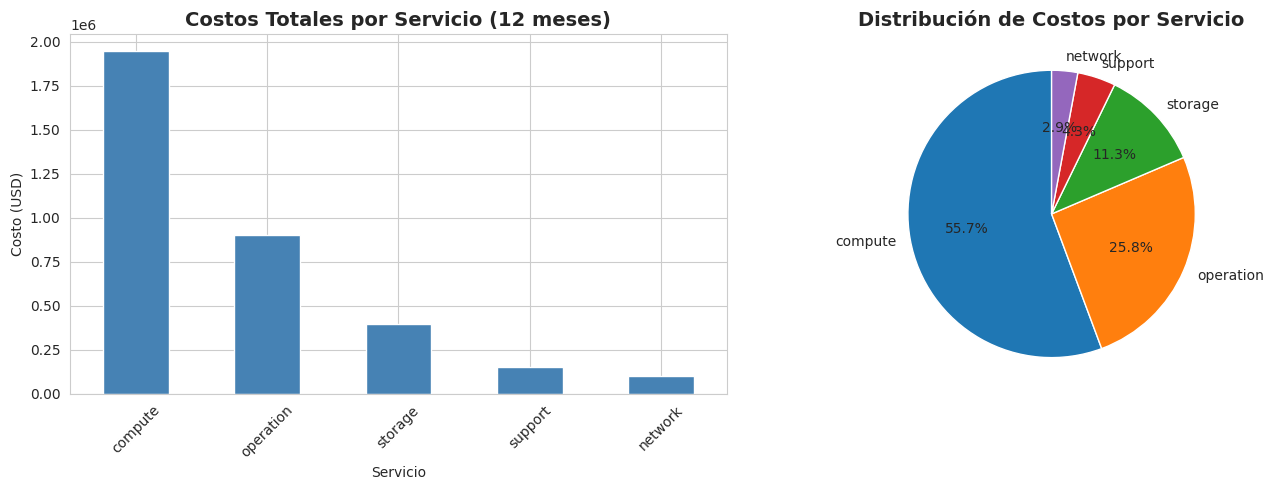

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# Agrupar por servicio
costs_by_service = df_events.groupby('service')['cost_usd'].sum().sort_values(ascending=False)

print("💰 Costos Totales por Servicio (12 meses):")
for service, cost in costs_by_service.items():
    pct = (cost / total_events) * 100
    print(f"   {service:<12} ${cost:>12,.2f}  ({pct:>5.1f}%)")

# Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
costs_by_service.plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Costos Totales por Servicio (12 meses)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Servicio')
ax1.set_ylabel('Costo (USD)')
ax1.tick_params(axis='x', rotation=45)

# Gráfico de pie
costs_by_service.plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=90)
ax2.set_title('Distribución de Costos por Servicio', fontsize=14, fontweight='bold')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

## 📊 Serie Temporal de Costos

Analizar evolución mensual (preparación para forecast):

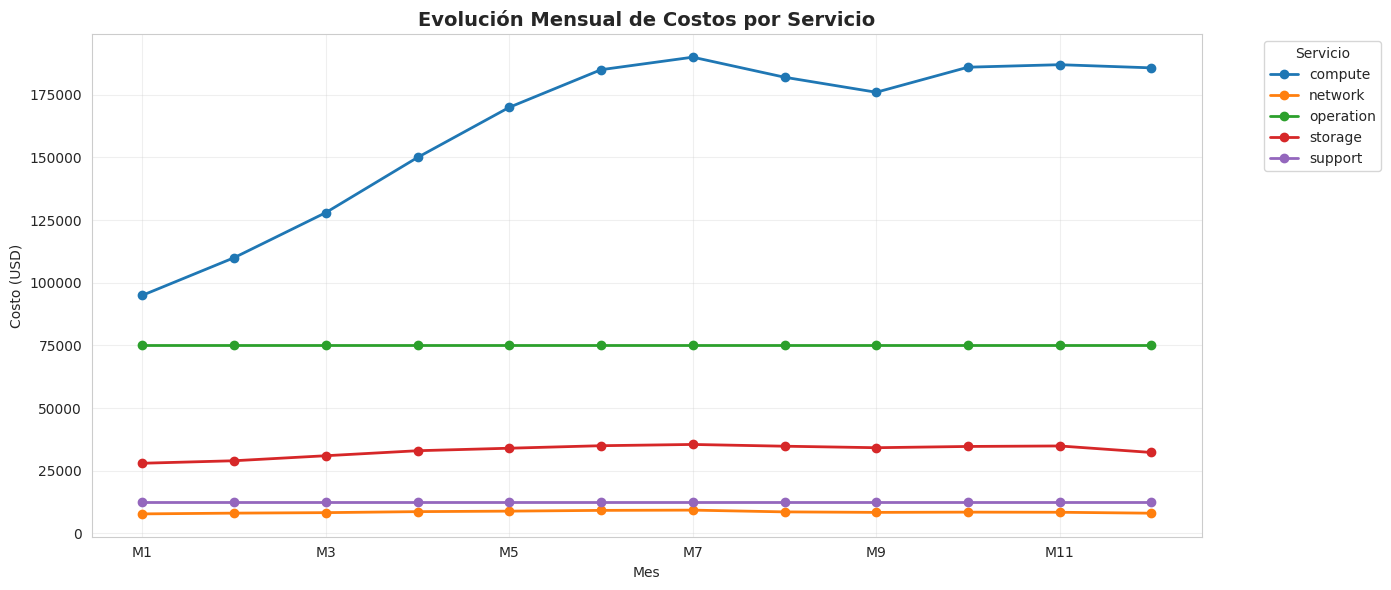

In [11]:
# Pivot: meses como filas, servicios como columnas
pivot_costs = df_events.pivot_table(
    index='month',
    columns='service',
    values='cost_usd',
    aggfunc='sum'
)

# Ordenar por mes
month_order = [f'M{i}' for i in range(1, 13)]
pivot_costs = pivot_costs.reindex(month_order)

# Visualización
fig, ax = plt.subplots(figsize=(14, 6))

pivot_costs.plot(kind='line', marker='o', ax=ax, linewidth=2)
ax.set_title('Evolución Mensual de Costos por Servicio', fontsize=14, fontweight='bold')
ax.set_xlabel('Mes')
ax.set_ylabel('Costo (USD)')
ax.legend(title='Servicio', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 🎓 Ejemplo: Consumir Eventos Como en Producción

Simulamos cómo el código consumiría eventos de Kafka:

In [12]:
def consume_billing_events(source):
    """
    Función genérica que consume eventos.
    
    En MVP:        source = open('kafka_events_billing.jsonl')
    En Producción: source = KafkaConsumer('billing.cost.monthly')
    """
    events = []
    
    for line in source:
        if isinstance(line, bytes):
            # Kafka devuelve bytes
            event = json.loads(line.decode('utf-8'))
        else:
            # Archivo JSONL devuelve strings
            event = json.loads(line)
        
        events.append(event)
    
    return events

# MVP: Consumir desde archivo
print("🔧 MVP: Consumiendo eventos desde archivo JSONL...")
with open('../data/kafka_events_billing.jsonl', 'r') as f:
    events_mvp = consume_billing_events(f)

print(f"   ✅ Consumidos {len(events_mvp)} eventos")
print(f"\n   Evento ejemplo:")
print(json.dumps(events_mvp[0], indent=2))

print("\n" + "="*60)
print("\n🚀 Producción: Solo cambiar la fuente:")
print("""
from kafka import KafkaConsumer

consumer = KafkaConsumer(
    'billing.cost.monthly',
    bootstrap_servers=['kafka-hub.gcp.internal:9092']
)

events_prod = consume_billing_events(consumer)
""")
print("✅ EL MISMO código de procesamiento, solo cambió la fuente.")

🔧 MVP: Consumiendo eventos desde archivo JSONL...
   ✅ Consumidos 60 eventos

   Evento ejemplo:
{
  "timestamp": "2025-01-01T00:00:00Z",
  "period": "monthly",
  "month": "M1",
  "project_id": "prod-industrial-fleet",
  "service": "compute",
  "sku": "n2-standard-fleet",
  "cost_usd": 95000.0,
  "usage_amount": 684000.0,
  "usage_unit": "vCPU-hours",
  "production_units": 130000,
  "labels": {
    "env": "prod",
    "business_unit": "industrial-operations",
    "cost_center": "CC-1000"
  }
}


🚀 Producción: Solo cambiar la fuente:

from kafka import KafkaConsumer

consumer = KafkaConsumer(
    'billing.cost.monthly',
    bootstrap_servers=['kafka-hub.gcp.internal:9092']
)

events_prod = consume_billing_events(consumer)

✅ EL MISMO código de procesamiento, solo cambió la fuente.


## 🎯 Conclusiones

### ✅ Ventajas del Enfoque Event-First

1. **Cero Deuda Técnica**
   - El código del MVP ES el código de producción
   - No hay refactoring al pasar a producción

2. **Validación Arquitectónica Temprana**
   - Comprobamos que el diseño event-driven funciona
   - Identificamos problemas antes de invertir en infraestructura

3. **Prototipado Rápido**
   - De datos históricos a modelo funcionando en días
   - No esperamos a tener Kafka desplegado

4. **Evolución Sin Fricción**
   - `source = open('events.jsonl')` → `source = KafkaConsumer(topic)`
   - Solo 1 línea de código cambia

### 📊 Métricas de Validación

- ✅ Eventos generados: 72 (60 billing + 12 production)
- ✅ Diferencia CSV vs eventos: $0.00
- ✅ Granularidad: Mensual (igual que CSV)
- ✅ Esquema: Compatible con arquitectura Kafka

### 🚀 Próximos Pasos

1. **Notebook 01**: Forecast de costos usando estos eventos
2. **Notebook 02**: Detección de anomalías
3. **Notebook 03**: NLP para etiquetado automático

---

**💡 Lección Clave:** 
> No es "crear un MVP y luego reescribirlo".  
> Es "crear producción desde el día 1, con datos simulados".